
## Setup




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)



## Load data and structural inspection and null checks

1. Both train.json and test.json are loaded and their shapes printed immediately.

2. We check whether missing values are explicit NaNs.

3. We expose column dtypes, which is crucial when text fields may contain empty strings instead of NaNs.


In [2]:
train = pd.read_json("train.json")
test  = pd.read_json("test.json")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (21021, 4)
Test shape: (2000, 5)


,answer,type,context,question
0,"In 1512, Parliament passed a significant act t...",factual,During the Hundred Years' War a French attack ...,In what year did Parliament pass a notable law...
1,The Spanish and French were the ones who estab...,factual,"""By May 1539, Conquistador Hernando de Soto sk...",Who established early settlements in Florida
2,"Traditionally, monsoons in Punjab are expected...",factual,The onset of the southwest monsoon is anticipa...,When do monsoons traditionally happen in Punjab?
3,The media made the requests for Kondo to use o...,factual,Media requests at the trade show prompted Kond...,Who made the requests for Kondo to use orchest...
4,According to historians Robert Friedel and Pau...,factual,In addressing the question of who invented the...,How many inventors came up with electric lamps...


In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21021 entries, 0 to 21020
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   answer    21021 non-null  object
 1   type      21021 non-null  object
 2   context   21021 non-null  object
 3   question  21021 non-null  object
dtypes: object(4)
memory usage: 657.0+ KB


In [4]:
train.isnull().sum()


,0
answer,0
type,0
context,0
question,0


In [5]:
def empty_count(col):
    return (train[col].astype(str).str.strip() == "").sum()

for c in ["context", "answer", "question", "type"]:
    print(c, "empty strings:", empty_count(c))


context empty strings: 1869
answer empty strings: 0
question empty strings: 0
type empty strings: 0



## Label Analysis

This establishes:

1. Class balance or imbalance

2. Whether any labels are missing or malformed

In [6]:
train["type"].value_counts(dropna=False)

,count
type,
factual,17431
contradiction,1818
irrelevant,1772


In [7]:
train["type"].value_counts(normalize=True, dropna=False)


,proportion
type,
factual,0.829218
contradiction,0.086485
irrelevant,0.084297


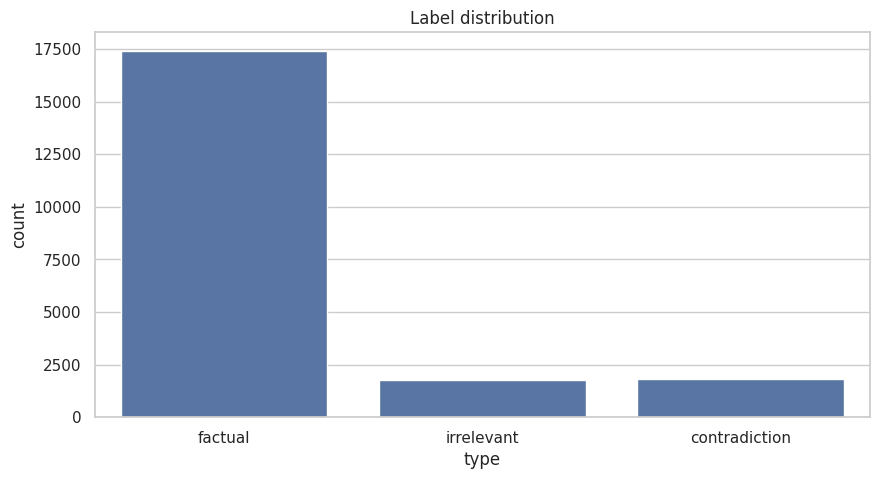

In [8]:
sns.countplot(data=train, x="type")
plt.title("Label distribution")
plt.show()


## Length Analysis

Observations:

Across all three labels, the distributions are almost identical.

Medians cluster tightly around ~100 tokens. Interquartile ranges overlap heavily. Whiskers extend to roughly the same range. Outliers exist for all classes, not just one.

Context:

Mean ≈ 109 tokens

Median ≈ 106

75 percent of samples are below 138 tokens

Long tail up to 653 tokens

Answer:

Mean ≈ 14 tokens

Very tight distribution

Long answers are rare but exist

Question:

Mean ≈ 10 tokens

Extremely stable

Almost no variance relative to context

Most of the variability lies in the context, not the question or answer.

In [9]:
for col in ["context", "answer", "question"]:
    train[f"{col}_len"] = train[col].astype(str).str.split().str.len()


In [10]:
train[[c for c in train.columns if c.endswith("_len")]].describe()


,context_len,answer_len,question_len
count,21021.000000,21021.000000,21021.000000
mean,109.056848,14.325769,10.072261
std,57.754782,6.894050,3.586801
min,0.000000,1.000000,2.000000
25%,83.000000,10.000000,8.000000
50%,106.000000,13.000000,10.000000
75%,138.000000,18.000000,12.000000
max,653.000000,92.000000,34.000000


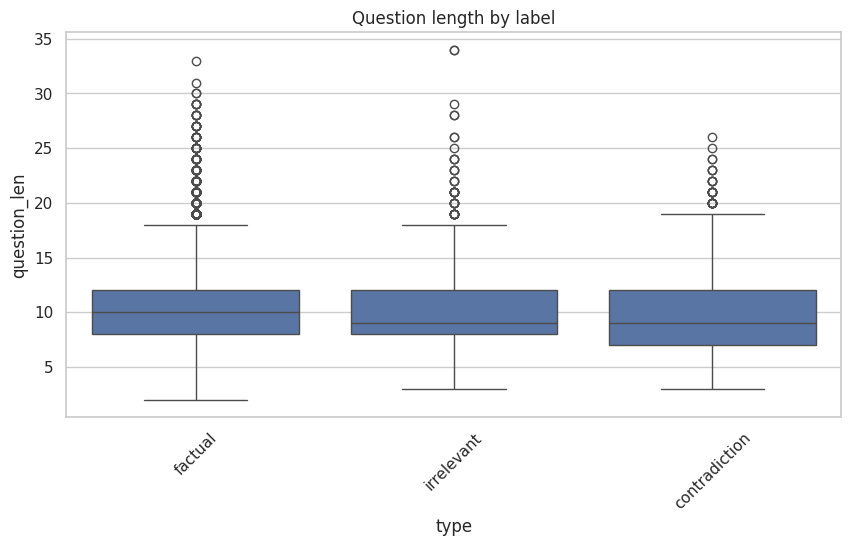

In [11]:
sns.boxplot(data=train, x="type", y="question_len")
plt.xticks(rotation=45)
plt.title("Question length by label")
plt.show()


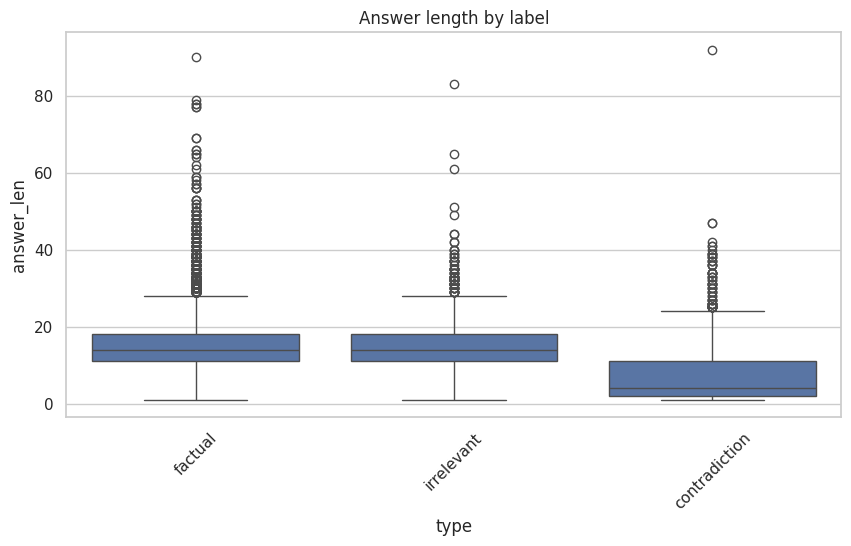

In [12]:
sns.boxplot(data=train, x="type", y="answer_len")
plt.xticks(rotation=45)
plt.title("Answer length by label")
plt.show()


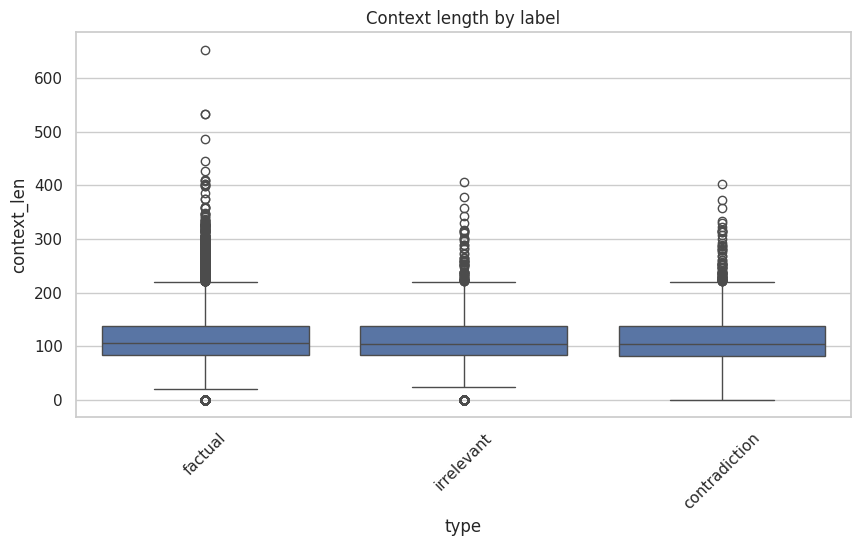

In [13]:
sns.boxplot(data=train, x="type", y="context_len")
plt.xticks(rotation=45)
plt.title("Context length by label")
plt.show()


## Empty samples



In [14]:
empty_context = train[train["context"].astype(str).str.strip() == ""]
empty_context.shape

(1869, 7)

In [15]:
empty_context.sample(5)


,answer,type,context,question,context_len,answer_len,question_len
11459,"Along with ethnicity and religion, nationality...",factual,,"Along with ethnicity and and religion, what ot...",0,27,16
16869,The mission of the European Central Bank is ou...,irrelevant,,When did the FCC rule on net neturality?,0,16,8
15865,The language spoken by ethnic Estonians was Es...,factual,,What language was spoken by ethnic Estonians?,0,8,7
3929,The war that occurred after the end of World W...,factual,,What war occurred after the end of World War II?,0,15,10
18626,Daurentius was the one who killed an envoy of ...,factual,,Who slew an envoy of Khagan Bayan I?,0,12,8


## Check if answer is present in context

Observations: For irrelevant, the answer never appears in the context. It is not a precise way to distinguish the other types.

In [16]:
def answer_in_context(row):
    return row["answer"].lower() in row["context"].lower()

train["answer_in_context"] = train.apply(answer_in_context, axis=1)
train["answer_in_context"].mean()


np.float64(0.007896865039722183)

In [17]:
train.query("answer_in_context == True")

,answer,type,context,question,context_len,answer_len,question_len,answer_in_context
745,Africans,contradiction,For the anthropologists Lieberman and Jackson ...,"What would the diverse group of East Indians, ...",188,1,19,True
1127,Most humans are not easily infected.,factual,Infection begins when an organism successfully...,What group is not easily infected?,122,6,6,True
1777,Islamic influence in Tibet also came from Persia.,factual,Muslims have been living in Tibet since as ear...,Where did Islamic influence in Tibet come from?,131,8,8,True
2132,0,contradiction,"In-mid 2015, China started the build-up of the...",How many BDS-3 satellites have been launched?,39,1,7,True
2299,Homosexuality,contradiction,The SASO consists of 12 questions. Six of thes...,What questions corresponds to the homosexual o...,87,1,7,True
...,...,...,...,...,...,...,...,...
20467,Beatrice,contradiction,"In 1853, Victoria gave birth to her eighth chi...",Who was Victoria's eighth child?,120,1,5,True
20483,American Idol,contradiction,The two finalists in 2011 were Lauren Alaina a...,What is the name of the successful album that ...,104,2,14,True
20657,10%,contradiction,Approximately 10% of the country's population ...,What percentage of the population continues to...,42,1,10,True
20816,2,contradiction,"On July 11, 1877, a few days after the Bell Te...",How many children did Bell and Mabel have?,156,1,8,True


In [18]:
train.groupby("type")["answer_in_context"].mean()


,answer_in_context
type,
contradiction,0.063256
factual,0.002926
irrelevant,0.000000


## Test vs train drift
Observations:

The train and test density curves almost sit on top of each other.

There is no visible shift in mean, variance, or tail behavior.

This means:

Validation results are trustworthy. Length-based heuristics will behave the same at test time as they do in training.

In [19]:
for col in ["context", "answer", "question"]:
    test[f"{col}_len"] = test[col].astype(str).str.split().str.len()

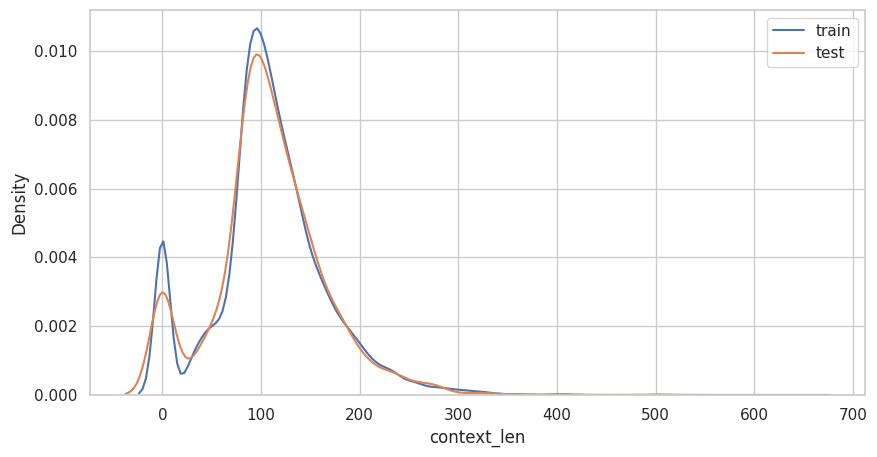

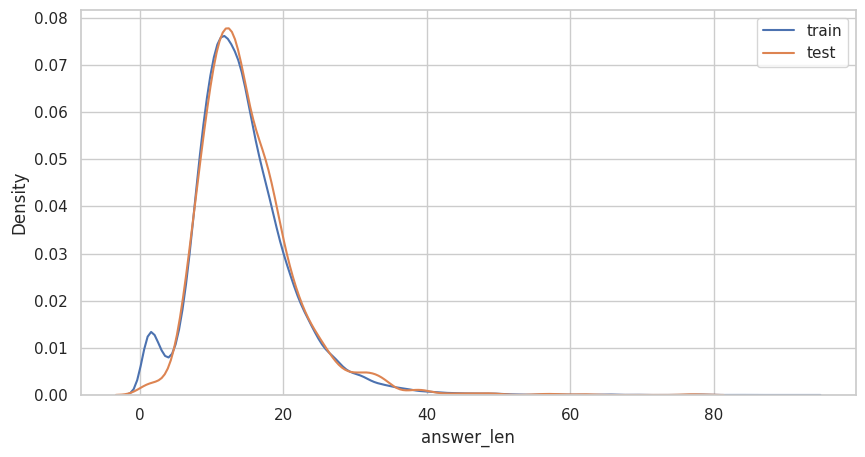

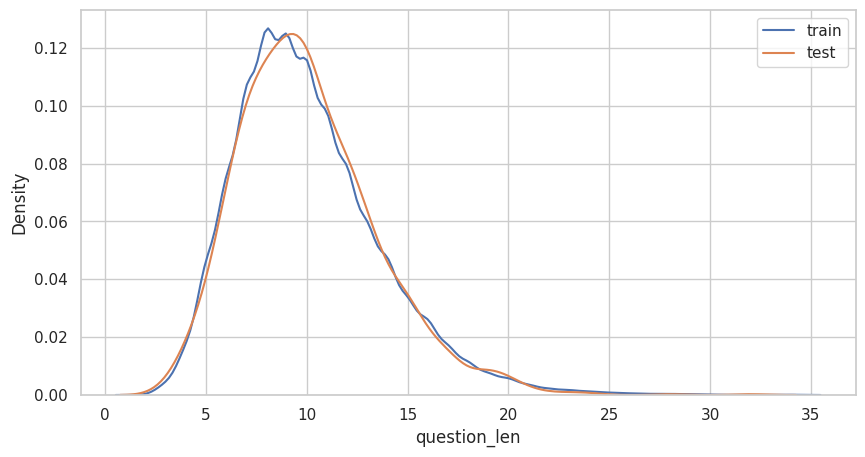

In [20]:
for col in ["context_len", "answer_len", "question_len"]:
    sns.kdeplot(train[col], label="train")
    sns.kdeplot(test[col], label="test")
    plt.legend()
    plt.show()
